In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
    #    print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Prepare Data for YOLOv5 Format

**Create directories to hold images and txt files for annotations (train , val ,test)**

In [2]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

**classes**

In [3]:
classes = ['helmet','head','person']

**calculate ancor points and hiegt width of bonding boxes**

In [4]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]


In [5]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/kaggle/working/Dataset/labels/' +  img_jpg_file_name + '.txt'
    print(save_file_name)
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [6]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [7]:
!ls /kaggle/working/Dataset/labels

In [8]:
files = os.listdir('/kaggle/input/hard-hat-detection/annotations')
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    print(file_xml[0])
    get_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

file name:  hard_hat_workers1531.xml
hard_hat_workers1531
/kaggle/working/Dataset/labels/hard_hat_workers1531.txt
file name:  hard_hat_workers4092.xml
hard_hat_workers4092
/kaggle/working/Dataset/labels/hard_hat_workers4092.txt
file name:  hard_hat_workers2006.xml
hard_hat_workers2006
/kaggle/working/Dataset/labels/hard_hat_workers2006.txt
file name:  hard_hat_workers3414.xml
hard_hat_workers3414
/kaggle/working/Dataset/labels/hard_hat_workers3414.txt
file name:  hard_hat_workers4190.xml
hard_hat_workers4190
/kaggle/working/Dataset/labels/hard_hat_workers4190.txt
file name:  hard_hat_workers324.xml
hard_hat_workers324
/kaggle/working/Dataset/labels/hard_hat_workers324.txt
file name:  hard_hat_workers4181.xml
hard_hat_workers4181
/kaggle/working/Dataset/labels/hard_hat_workers4181.txt
file name:  hard_hat_workers3912.xml
hard_hat_workers3912
/kaggle/working/Dataset/labels/hard_hat_workers3912.txt
file name:  hard_hat_workers3704.xml
hard_hat_workers3704
/kaggle/working/Dataset/labels/ha

# split train val test

In [9]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/kaggle/input/hard-hat-detection/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [10]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/kaggle/working/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('/kaggle/working/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = '/kaggle/working/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/kaggle/working/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [11]:
copy_data(train_list, '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "train")
copy_data(val_list,   '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "val")
copy_data(test_list,  '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "test")

Path /kaggle/working/Dataset/images/train does not exit
Path /kaggle/working/Dataset/labels/train does not exit
Path /kaggle/working/Dataset/images/val does not exit
Path /kaggle/working/Dataset/labels/val does not exit
Path /kaggle/working/Dataset/images/test does not exit
Path /kaggle/working/Dataset/labels/test does not exit


In [12]:
!ls /kaggle/working/Dataset/images

test  train  val


# Get YOLOv5 model

In [13]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16114, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 16114 (delta 8), reused 10 (delta 1), pack-reused 16089
Receiving objects: 100% (16114/16114), 14.79 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (11032/11032), done.
/kaggle/working/yolov5


In [14]:
!ls 

CITATION.cff	 README.zh-CN.md  detect.py   requirements.txt	tutorial.ipynb
CONTRIBUTING.md  benchmarks.py	  export.py   segment		utils
LICENSE		 classify	  hubconf.py  setup.cfg		val.py
README.md	 data		  models      train.py


**create yaml file for configuration**

In [15]:
import yaml

dict_file = {'train':'/kaggle/working/Dataset/images/train' ,
            'val': '/kaggle/working/Dataset/images/val',
            'nc' : '3',
            'names' : ['helmet','head','person']}

with open('/kaggle/working/yolov5/data/hard_head.yaml', 'w+') as file:
    documents = yaml.dump(dict_file, file)

# Train Net

In [16]:
!wandb disabled

W&B disabled.


In [17]:
!python train.py --img 416 --batch 32 --epochs 30 --data data/hard_head.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

     |████████████████████████████████| 616 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 61.7 MB 141 kB/s  eta 0:00:01
     |████████████████████████████████| 614 kB 60.0 MB/s eta 0:00:01
     |████████████████████████████████| 614 kB 62.8 MB/s eta 0:00:01
     |████████████████████████████████| 606 kB 63.1 MB/s eta 0:00:01
     |████████████████████████████████| 606 kB 58.6 MB/s eta 0:00:01
     |████████████████████████████████| 605 kB 54.5 MB/s eta 0:00:01
     |████████████████████████████████| 605 kB 54.5 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 6.1 MB/s  eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.1.48
    Uninstalling opencv-python-4.5.1.48:
      Successfully uninstalled opencv-python-4.5.1.48
wandb: WARNING ⚠️ wandb is deprecated and w

# Detect (predict)

In [18]:
#!python detect.py --source /kaggle/working/Dataset/images/test --img-size 416 --conf 0.4 --weights weights.pt 
!python detect.py --source /kaggle/working/Dataset/images/test  --weights yolov5s.pt --conf 0.25

detect: weights=['yolov5s.pt'], source=/kaggle/working/Dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
ERROR: Could not find a version that satisfies the requirement Pillow>=10.0.1
ERROR: No matching distribution found for Pillow>=10.0.1
requirements: ❌ Command 'pip install --no-cache "gitpython>=3.1.30" "Pillow>=10.0.1"  ' returned non-zero exit status 1.
YOLOv5 🚀 v7.0-253-g63555c8 Python-3.7.10 torch-1.7.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7

In [19]:
# display detected images
from IPython.display import Image

<function matplotlib.pyplot.show(close=None, block=None)>

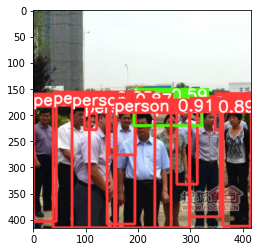

In [22]:
from glob import glob
import matplotlib.pyplot as plt
testfiles = glob('runs/detect/exp/*')

img = plt.imread(testfiles[354]) 
plt.imshow(img)    
plt.show